In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

df_true = pd.read_csv('/content/drive/My Drive/Machine Learning Notebooks/Fake News Detection/True.csv')
df_fake = pd.read_csv('/content/drive/My Drive/Machine Learning Notebooks/Fake News Detection/Fake.csv')

Mounted at /content/drive


In [6]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
print(f"The length of the True class is: {df_true.shape[0]}")
print(f"The length of the Fake class is: {df_fake.shape[0]}")

The length of the True class is: 21417
The length of the Fake class is: 23481


In [9]:
print(f"Null values in the true dataset:\n {df_true.isnull().sum()}")
print('\n')
print(f"Null values in the fake dataset:\n{df_fake.isnull().sum()}")

Null values in the true dataset:
 title      0
text       0
subject    0
date       0
dtype: int64


Null values in the fake dataset:
title      0
text       0
subject    0
date       0
dtype: int64


In [10]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [11]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


### Feature engineering and data cleaning

In [12]:
# Append the is_fake target column to both datasets
df_true['is_fake'] = 0
df_fake['is_fake'] = 1

# Create the combined dataset
df = pd.concat([df_true, df_fake]).reset_index(drop=True)
# Drop the date column
df = df.drop(columns=['date'])
# Make a new column called original that combines a news title and body
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,is_fake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0,Trump wants Postal Service to charge 'much mor...


In [13]:
# Get the stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'reuters'])

In [14]:
# Define a text preprocessing function
def preprocess_text(text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in stop_words and len(token)>3:
      result.append(token)
  return ' '.join(result)

In [15]:
# Preprocess the dataset
df['clean_text'] = df['original'].apply(preprocess_text)
df.head()

,title,text,subject,is_fake,original,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0,"As U.S. budget fight looms, Republicans flip t...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0,U.S. military to accept transgender recruits o...,military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0,Senior U.S. Republican senator: 'Let Mr. Muell...,senior republican senator mueller washington s...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0,FBI Russia probe helped by Australian diplomat...,russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0,Trump wants Postal Service to charge 'much mor...,trump wants postal service charge much amazon ...


[Text(0.5, 1.0, 'Distribution of News Subject')]

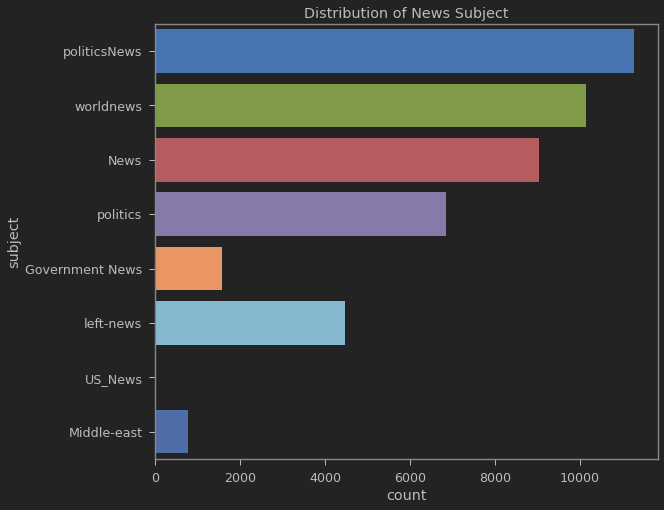

In [54]:
plt.figure(figsize=(9,8))
sns.countplot(y='subject', data=df).set(title='Distribution of News Subject')

[Text(0.5, 1.0, 'Fake and Valid News are Balanced')]

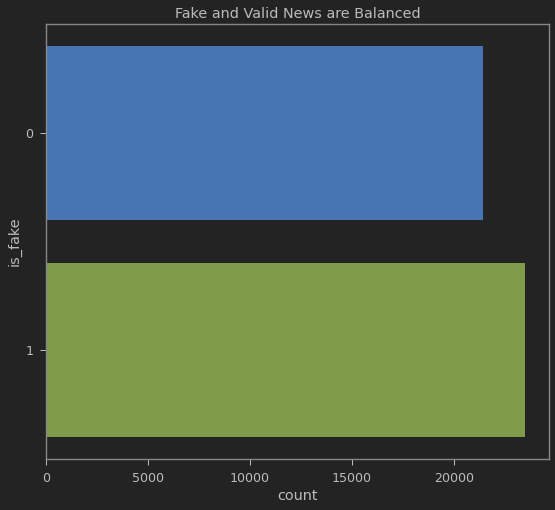

In [55]:
plt.figure(figsize=(9,8))
sns.countplot(y='is_fake', data=df).set(title='Fake and Valid News are Balanced')

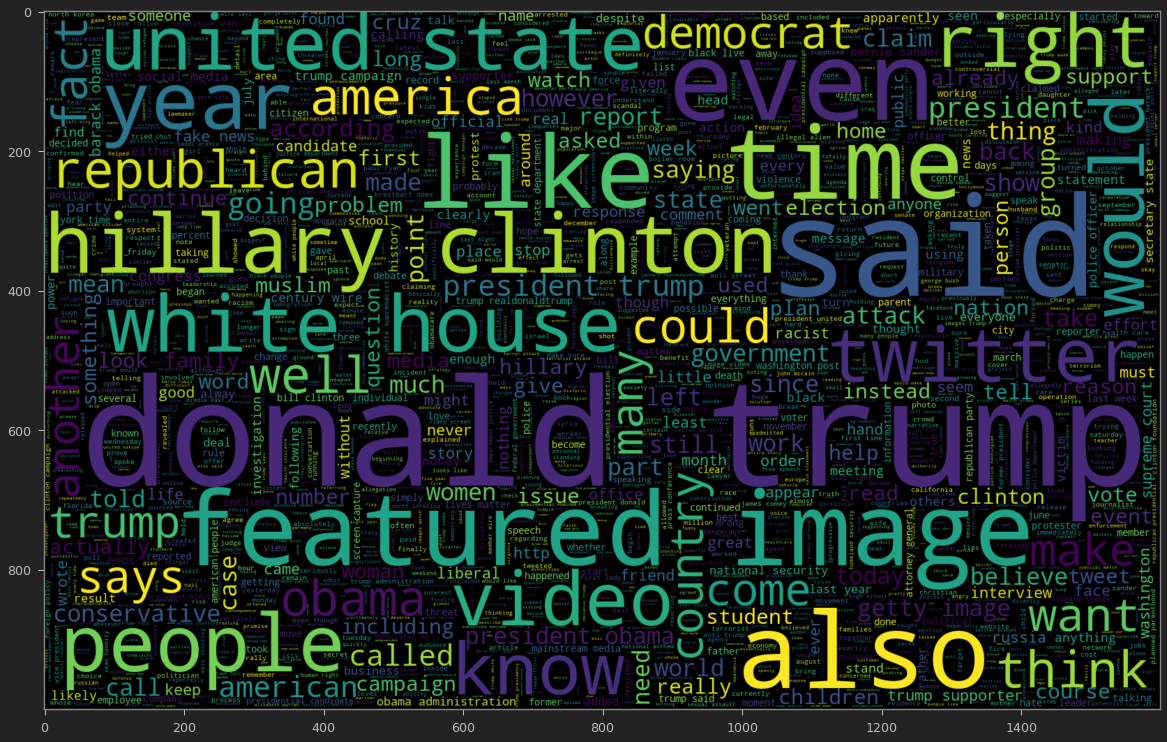

In [18]:
# Plot the most common words among the fake news
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000, width=1600, height=1000, stopwords=stop_words).generate(" ".join(df[df.is_fake==1].clean_text))
plt.imshow(wc, interpolation='bilinear')

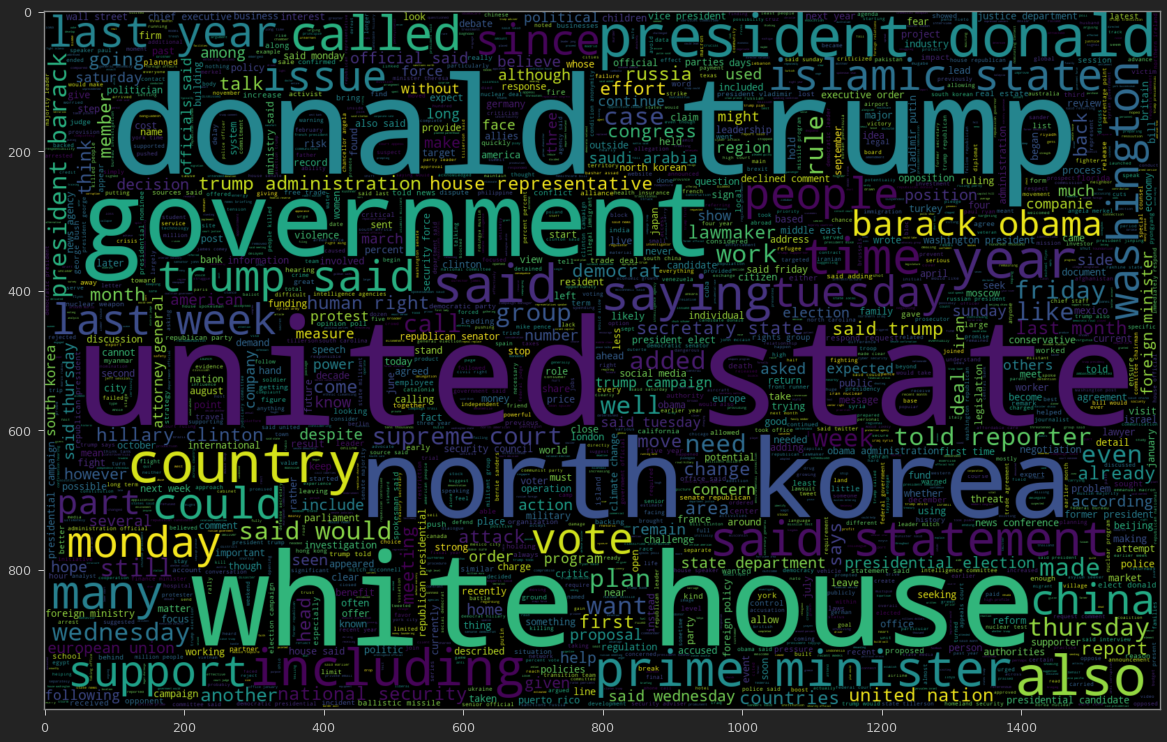

In [19]:
# Plot the most common words in the valid news
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000, width=1600, height=1000, stopwords=stop_words).generate(" ".join(df[df.is_fake==0].clean_text))
plt.imshow(wc, interpolation='bilinear')

In [20]:
# A function to calculate number of tokens in a string
def num_words(string):
  tokens = nltk.word_tokenize(string)
  string_length = len(tokens)
  return string_length

In [21]:
df['num_tokens'] = df['clean_text'].apply(num_words)
max_text_len = max(df['num_tokens'])
print(f"The maximum number of words in every text is: {max_text_len}")
df.drop(columns=['num_tokens'], inplace=True)

The maximum number of words in every text is: 4654


In [56]:
# Interactive plotly histogram
fig = px.histogram(x=[len(nltk.word_tokenize(x)) for x in df.clean_text], nbins=100, title='Distribution of News Length')
fig.show()

In [23]:
list_of_words = []
for i in df.clean_text:
  for j in i.split():
    list_of_words.append(j)

total_words = len(set(list_of_words))
print(f"Total number of uniqur words: {total_words}")

Total number of uniqur words: 108882


In [24]:
# Perform train and test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_text, df.is_fake, test_size=0.2)

In [25]:
# Make tokenized sequences
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [26]:
# Pad sequences to fit them to the same length
padded_train = pad_sequences(train_sequences, maxlen=max_text_len, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=max_text_len, padding='post', truncating='post')
# Turn y_train to an array
y_train = np.asarray(y_train)

In [27]:
# Building the model
model = Sequential()
# Adding the embedding layer
model.add(Embedding(total_words, output_dim = 128))
# Adding an LSTM layer
model.add(Bidirectional(LSTM(128)))
# Adding dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         13936896  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,233,089
Trainable params: 14,233,089
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Fit the model
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='fake_news_model.epoch:{02d}-{val_loss:.2f}.h5')
]
model.fit(padded_train, y_train, batch_size=64, validation_split=0.2, epochs=7, callbacks=my_callbacks)

449/449 [==============================] - 218s 468ms/step - loss: 0.0986 - acc: 0.9627 - val_loss: 0.0348 - val_acc: 0.9869


In [52]:
# Make predictions
pred = model.predict(x_test)
predictions = list(map(lambda x: 1 if x>0.5 else 0, pred))

In [53]:
# Print model metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy = accuracy_score(list(y_test), predictions)
precision = precision_score(list(y_test), predictions)
recall = recall_score(list(y_test), predictions)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.9870824053452116
Precision:  0.9886435331230284
Recall:  0.9869829939114004


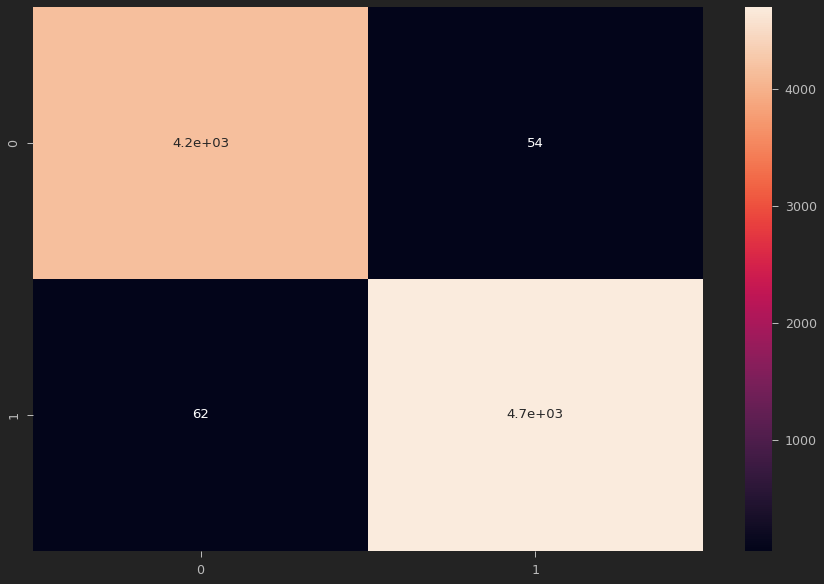

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), predictions)
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True)